In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("merged_data.csv", parse_dates=["date"])
data.set_index("date", inplace=True)

In [4]:
mfrr_up_data_for_lag = data[['LT_mfrr_SA_up_activ', 'latitude']]
mfrr_down_data_for_lag = data[['LT_mfrr_SA_down_activ', 'latitude']]

mfrr_up_data_for_lag = mfrr_up_data_for_lag.groupby('latitude').shift(3)
mfrr_down_data_for_lag = mfrr_down_data_for_lag.groupby('latitude').shift(3)

data['mfrr_up_lag3'] = mfrr_up_data_for_lag['LT_mfrr_SA_up_activ']
data['mfrr_down_lag3'] = mfrr_down_data_for_lag['LT_mfrr_SA_down_activ']

data = data.dropna()


Training RMSE: 11.22773520137078
Training R²: 0.831566369405992
Test RMSE: 14.033989612762412
Test R²: 0.7373988995902708

Feature Importance:
mfrr_up_lag3                                      0.212499
mfrr_down_lag3                                    0.195472
direct_normal_irradiance_instant_previous_day1    0.077183
shortwave_radiation_previous_day1                 0.066067
temperature_2m_previous_day1                      0.055589
wind_direction_80m_previous_day1                  0.055396
wind_speed_80m_previous_day1                      0.051759
10YLT-1001A0008Q_DA_eurmwh                        0.049685
direct_normal_irradiance_delta                    0.047756
temperature_delta                                 0.040877
shortwave_radiation_delta                         0.037777
wind_speed_80m_delta                              0.033020
longitude                                         0.025962
latitude                                          0.025523
wind_direction_80m_delta       

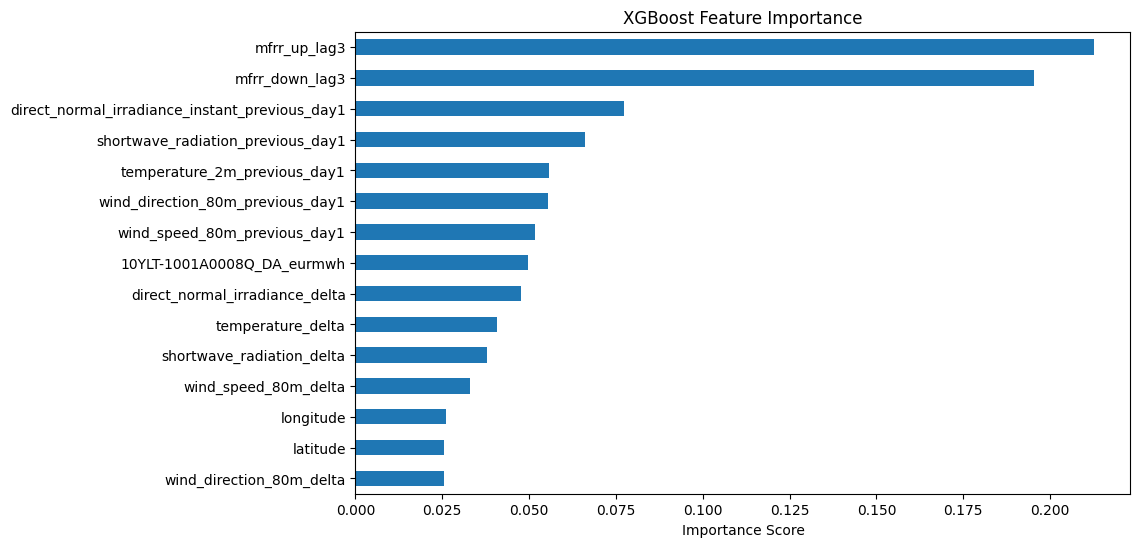

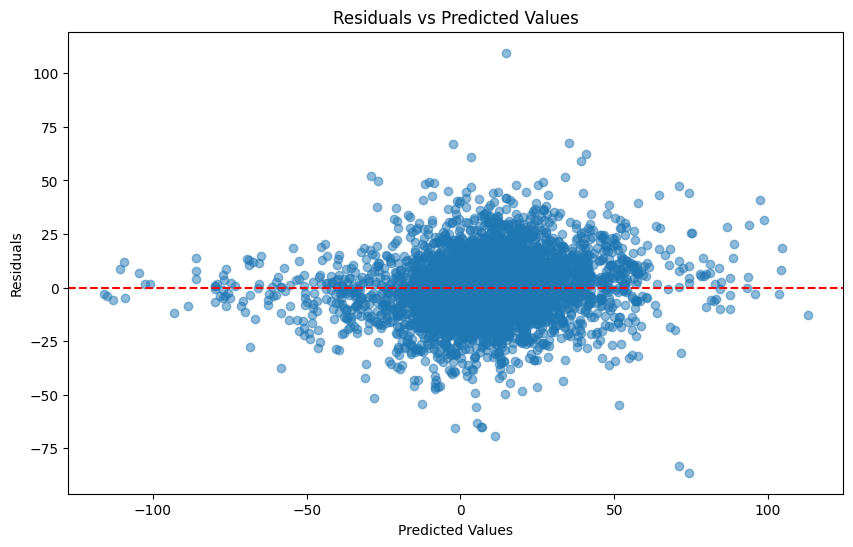

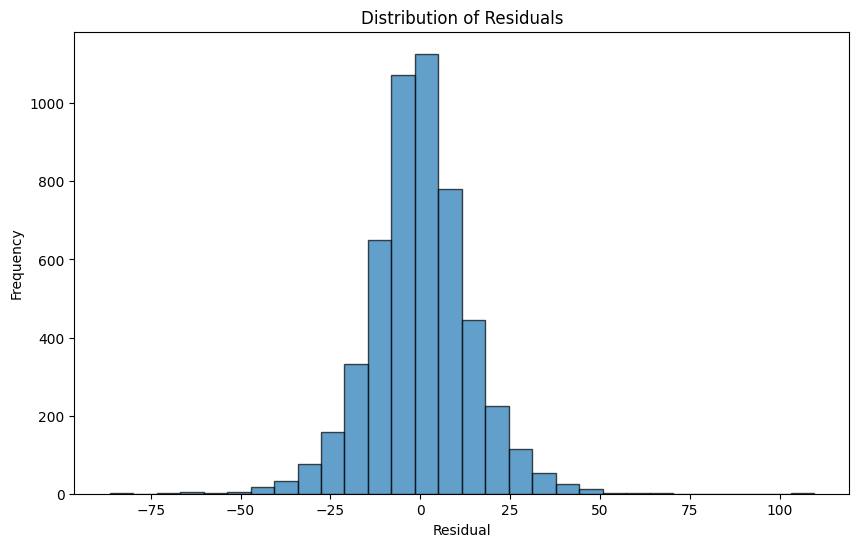

In [5]:
features = [
       '10YLT-1001A0008Q_DA_eurmwh',
       'temperature_2m_previous_day1', 
       'direct_normal_irradiance_instant_previous_day1',
       'shortwave_radiation_previous_day1',
       'wind_speed_80m_previous_day1',
       'wind_direction_80m_previous_day1', 'latitude', 'longitude',
       'temperature_delta', 'direct_normal_irradiance_delta',
       'shortwave_radiation_delta', 'wind_speed_80m_delta',
       'wind_direction_80m_delta', 'mfrr_up_lag3',
       'mfrr_down_lag3'
    ]

#Features for test without deltas

# features = [
#        '10YLT-1001A0008Q_DA_eurmwh',
#        'temperature_2m_previous_day1', 
#        'direct_normal_irradiance_instant_previous_day1',
#        'shortwave_radiation_previous_day1',
#        'wind_speed_80m_previous_day1',
#        'wind_direction_80m_previous_day1','latitude', 'longitude', 
#        'mfrr_up_lag3', 'mfrr_down_lag3'
#   ]

target= 'LT_imb_MW'
# target = 'LT_mfrr_SA_up_activ'
# target = 'LT_mfrr_SA_down_activ'


X = data[features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)



train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)


print(f"Training RMSE: {train_rmse}")
print(f"Training R²: {train_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")


feature_importance = pd.Series(model.feature_importances_, index=features)
print("\nFeature Importance:")
print(feature_importance.sort_values(ascending=False))



plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()


residuals = y_test - y_pred_test


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()